This notebook will explain how to use the ADMM.

Basically, the core of the algorithm is inside the ADMM class (admm.py). The constructor takes as input all the initial parameters, then the method iterate will run the algorithm. However, there is a lot of parameters and some pre-processing needed that we will detail here.

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
from astropy.io import fits as fits
import matplotlib.pylab as plt

from DeepDeconv.deepnet.DeepNet import DeepNet
from DeepDeconv.admm.admm import ADMM
from DeepDeconv.utils.batch_utils import admm_data

/local/home/alechat/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/local/home/alechat/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/local/home/alechat/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/local/home/alechat/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


First, we initialise the hyper parameters:

In [2]:
#PARAMETERS ADMM
max_iter = 20 #maximal number of iterations
gamma = 1.4 #value of gamma used for the update of rho
rho = 50 #initial value of rho
rho_cap = 200 #higher limit of rho. 
eta = 0.5 #value of eta which determines the update rule of rho
opti_method = 'FISTA' #chose between 'FISTA' or 'GD' (gradient descent) for the inversion step

Then we have to set the initial values of the ADMM variables X, Z and mu.

The normal way is to set everything to 0.

In [3]:
mu = np.zeros((96,96))
x = np.zeros((96,96))
z = np.zeros((96,96))

Then you need to instanciate the network used for denoising

In [4]:
model_file = '/data/DeepDeconv/model/Denoiser_net_vsc_swish_noise0p04.hdf5'
dnn = DeepNet(network_name='ADMM net', model_file=model_file)

Loadind model...
/data/DeepDeconv/model/Denoiser_net_vsc_swish_noise0p04.hdf5


At last, we need the data to deconvolve. The algorithm need the image to deconvolve, the PSF and the standard deviation of the noise sigma.

A function admm_data is available to generates data from fits files similar to those used for the neural network.

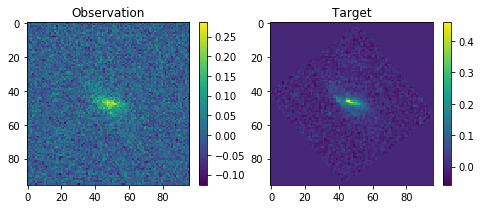

In [5]:
fits_file = '/data/DeepDeconv/data/vsc_euclidpsfs/image-000-0.fits'
idx = 0 #idx of the galaxy (between 0 and 9999 for our files)
SNR = 50 #we add noise such as the SNR is 50

observation, target, psf, snr_img, noise_std = admm_data(fits_file, idx, noise_std=None, SNR=SNR,
                                                         noiseless_img_hdu=1, targets_hdu=4, psf_hdu=3,
                                                         image_dim=96, image_per_row=100)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(observation)
plt.colorbar()
plt.title('Observation')
plt.subplot(122)
plt.imshow(target)
plt.colorbar()
plt.title('Target')
plt.show()

All that is left is to instanciate the ADMM and run it.

/data/DeepDeconv/code/DeepDeconv/utils/conv_utils.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ext_psf[cur_slice]= psf
/local/home/alechat/miniconda3/lib/python3.5/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


 - Converged after 8 iterations


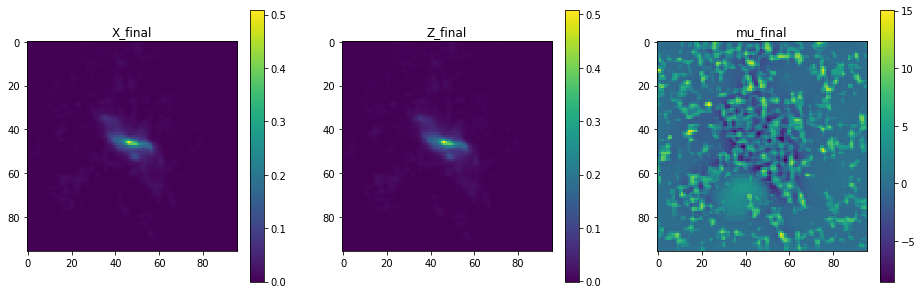

In [6]:
ad = ADMM(x, z, mu, observation, psf, noise_std, dnn, rho=rho, rho_cap=rho_cap, gamma=gamma, eta=eta,
                  opti_method=opti_method)

ad.iterate(max_iter=max_iter, plot_iter=1, verbose=False, plot_verbose=False)
# verbose allows to print or not the cost function and the euclidean distance between X and Z
# plot_verbose allows or note to plot the images of X and Z at each iterations

# the output of the algorithm (the 3 variables) are directly stored as attributes.
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(ad.x_final)
plt.title('X_final')
plt.colorbar()
plt.subplot(132)
plt.imshow(ad.z_final)
plt.title('Z_final')
plt.colorbar()
plt.subplot(133)
plt.imshow(ad.mu_final)
plt.title('mu_final')
plt.colorbar()
plt.show()

Remark: our ground truths (GTs) are images convolved by a gaussian PSF of FWHM = 0.07 arcsec. Nowhere in this method it is taken into account, so we converge toward a sharper resolution than our GTs.

To take this PSF into account, it is necessary to do a pre-processing on the PSF before calling the ADMM.

In [7]:
from numpy.fft import fft2, ifft2, fftshift
from utils.conv_utils import perform_shift_in_frequency

#ADD GAUSSIAN PSF
psf_file = '/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits'
psf_gauss = fits.getdata(psf_file)
fft_gauss = fft2(psf_gauss)
fft = fft2(psf)
r = fft/fft_gauss
r[np.abs(fft_gauss)<1e-6] = 0
r = perform_shift_in_frequency(r, (96,96), np.array([1,1]))
psf = np.abs(fftshift(ifft2(r)))

/local/home/alechat/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [26]:
theta=np.random.uniform(size=(100))*math.pi

In [27]:
data=np.array([np.cos(theta),np.sin(theta)])

In [28]:
np.linalg.svd(data)

(array([[-0.85335957, -0.52132278],
        [-0.52132278,  0.85335957]]),
 array([7.13800578, 7.00349009]),
 array([[-0.12319203, -0.11356468,  0.11314978, ..., -0.13887693,
         -0.13955806, -0.00931276],
        [-0.06799244,  0.08361047,  0.08419278, ..., -0.01878907,
          0.01249092,  0.14247013],
        [ 0.14097673, -0.00793302,  0.98246479, ...,  0.01520654,
          0.01293761, -0.00971699],
        ...,
        [-0.12638495, -0.0607465 ,  0.0148398 , ...,  0.98308119,
         -0.0165212 ,  0.00106723],
        [-0.10969624, -0.08719811,  0.01243298, ..., -0.01635418,
          0.98315957, -0.00295694],
        [ 0.07082341, -0.12389544, -0.01036505, ...,  0.00183246,
         -0.00219917,  0.98161099]]))

In [30]:
u,d,v=np.linalg.svd(np.dot(data,data.T))

In [34]:
0.5*(v[0]+v[1])

array([-0.68734118,  0.16601839])

In [32]:
v[0]

array([-0.85335957, -0.52132278])